### Hyper Parameters Tuning
- With One-Hot Encoding for Logistic Regression: Must Use 
- With One-Hot Encoding for Catboost: Boost the performance (not for accuracy)
- No One-Hot Encoding for Random Forests: must consider OrdinalEncoder
- No One-Hot Encoding for xgboost: optional consider OrdinalEncoder
- No One-Hot Encoding for lightgbm: optional consider OrdinalEncoder

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

# to tune the hyperparameters
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


In [6]:
# Load the dataset
url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv'
df = pd.read_csv(url)

# Extract features and target
X = df.drop(columns=['survived', 'alive', 'pclass'])
y = df['survived']
# Declare pclass and survived as categorical
y = y.astype('category')

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Fill missing data using KNN imputation
imputer = KNNImputer(n_neighbors=5)  # You can set n_neighbors to the desired value
X_oh = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Impute numerical columns using KNN imputation
imputer_num = KNNImputer(n_neighbors=5)
X[numerical_cols] = imputer_num.fit_transform(X[numerical_cols])

# Impute categorical columns using SimpleImputer with the most frequent strategy
imputer_cat = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = imputer_cat.fit_transform(X[categorical_cols])

# Ordinal encode categorical columns
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

# Convert categorical columns to category type
for col in categorical_cols:
    X[col] = X[col].astype('category')

# Split the data into training and testing sets
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(X_oh, y, test_size=0.3, random_state=42, stratify=y)
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


### Logistic Regression

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'C': 10, 'max_iter': 10000, 'solver': 'lbfgs'}
Best cross-validation score: 0.8251
Accuracy for Test Set: 0.8134
Classification Report:
              precision    recall  f1-score   support

Not Survived       0.84      0.85      0.85       165
    Survived       0.76      0.75      0.75       103

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

Confusion Matrix:
[[141  24]
 [ 26  77]]
AUC: 0.8651


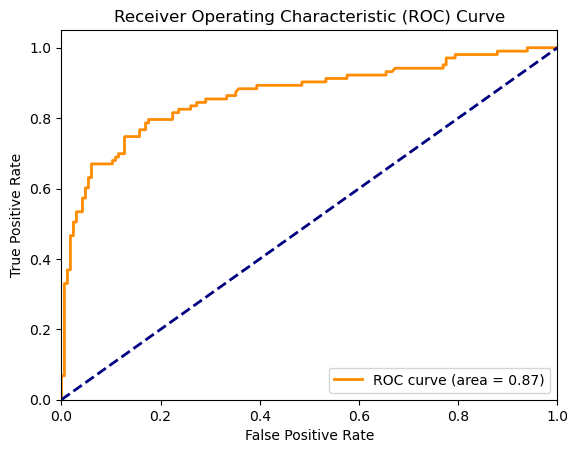

In [9]:
# Initialize logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [10000, 20000]
}

# Define the stratified k-fold cross-validator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_oh, y_train_oh)

# Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best parameters found: {best_params}')
print(f'Best cross-validation score: {best_score:.4f}')

# Display grid search results
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')

# Train the model with the best parameters
best_logistic_model = grid_search.best_estimator_

# Make predictions
y_pred = best_logistic_model.predict(X_test_oh)
y_pred_proba = best_logistic_model.predict_proba(X_test_oh)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test_oh, y_pred)
report = classification_report(y_test_oh, y_pred, target_names=['Not Survived', 'Survived'])
print(f'Accuracy for Test Set: {accuracy:.4f}')
print('Classification Report:')
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_oh, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_oh, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [10]:
# Initialize CatBoost model
catboost_model = CatBoostClassifier(random_state=42, eval_metric='Logloss', verbose=0)

# Define the parameter grid for tuning
param_grid = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Define the stratified k-fold cross-validator with shuffling
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with stratified cross-validation
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_oh, y_train_oh)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best parameters found: {best_params}')
print(f'Best cross-validation score: {best_score:.4f}')

# Display grid search results
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')


# Train the model with the best parameters
best_catboost_model = grid_search.best_estimator_

# Make predictions
y_pred = best_catboost_model.predict(X_test_oh)
y_pred_proba = best_catboost_model.predict_proba(X_test_oh)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test_oh, y_pred)
report = classification_report(y_test_oh, y_pred, target_names=['Not Survived', 'Survived'])
print(f'Accuracy for Test Set: {accuracy:.4f}')
print('Classification Report:')
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_oh, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_oh, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')



Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.05}
Best cross-validation score: 0.8395
Accuracy for Test Set: 0.8022
Classification Report:
              precision    recall  f1-score   support

Not Survived       0.81      0.88      0.85       165
    Survived       0.78      0.67      0.72       103

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268

Confusion Matrix:
[[146  19]
 [ 34  69]]
AUC: 0.8691


In [11]:
# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', enable_categorical=True, use_label_encoder=False)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define the stratified k-fold cross-validator with shuffling
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with stratified cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_ord, y_train_ord)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best parameters found: {best_params}')
print(f'Best cross-validation score: {best_score:.4f}')

# Use the best estimator from grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions
y_pred = best_xgb_model.predict(X_test_ord)
y_pred_proba = best_xgb_model.predict_proba(X_test_ord)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test_ord, y_pred)
report = classification_report(y_test_ord, y_pred, target_names=['Not Survived', 'Survived'])
print(f'Accuracy for Test Set: {accuracy:.4f}')
print('Classification Report:')
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_ord, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

fpr, tpr, thresholds = roc_curve(y_test_ord, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score: 0.8411
Accuracy for Test Set: 0.8246
Classification Report:
              precision    recall  f1-score   support

Not Survived       0.80      0.95      0.87       165
    Survived       0.88      0.63      0.73       103

    accuracy                           0.82       268
   macro avg       0.84      0.79      0.80       268
weighted avg       0.83      0.82      0.82       268

Confusion Matrix:
[[156   9]
 [ 38  65]]
AUC: 0.8741


In [12]:
# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42, verbosity=-1)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define the stratified k-fold cross-validator with shuffling
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with stratified cross-validation
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_ord, y_train_ord, categorical_feature=categorical_cols)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best parameters found: {best_params}')
print(f'Best cross-validation score: {best_score:.4f}')

# Use the best estimator from grid search
best_lgb_model = grid_search.best_estimator_

# Make predictions
y_pred = best_lgb_model.predict(X_test_ord)
y_pred_proba = best_lgb_model.predict_proba(X_test_ord)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test_ord, y_pred)
report = classification_report(y_test_ord, y_pred, target_names=['Not Survived', 'Survived'])
print(f'Accuracy for Test Set: {accuracy:.4f}')
print('Classification Report:')
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_ord, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

fpr, tpr, thresholds = roc_curve(y_test_ord, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}
Best cross-validation score: 0.8315
Accuracy for Test Set: 0.8209
Classification Report:
              precision    recall  f1-score   support

Not Survived       0.82      0.91      0.86       165
    Survived       0.82      0.68      0.74       103

    accuracy                           0.82       268
   macro avg       0.82      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268

Confusion Matrix:
[[150  15]
 [ 33  70]]
AUC: 0.8682


In [13]:
# Initialize RandomForest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the stratified k-fold cross-validator with shuffling
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with stratified cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_ord, y_train_ord)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best parameters found: {best_params}')
print(f'Best cross-validation score: {best_score:.4f}')

# Use the best estimator from grid search
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred = best_rf_model.predict(X_test_ord)
y_pred_proba = best_rf_model.predict_proba(X_test_ord)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test_ord, y_pred)
report = classification_report(y_test_ord, y_pred, target_names=['Not Survived', 'Survived'])
print(f'Accuracy for Test Set: {accuracy:.4f}')
print('Classification Report:')
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_ord, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

fpr, tpr, thresholds = roc_curve(y_test_ord, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8379
Accuracy for Test Set: 0.8022
Classification Report:
              precision    recall  f1-score   support

Not Survived       0.81      0.89      0.85       165
    Survived       0.79      0.66      0.72       103

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268

Confusion Matrix:
[[147  18]
 [ 35  68]]
AUC: 0.8500


In [17]:
# create the directory to save the model
import os
import joblib

if not os.path.exists('./models'):
    os.makedirs('./models')

joblib.dump(best_logistic_model, './models/best_logistic_model.pkl')
joblib.dump(best_catboost_model, './models/best_catboost_model.pkl')
joblib.dump(best_xgb_model, './models/best_xgb_model.pkl')
joblib.dump(best_lgb_model, './models/best_lgb_model.pkl')
joblib.dump(best_rf_model, './models/best_rf_model.pkl')


['./models/best_rf_model.pkl']